In [267]:
import pandas as pd
import seaborn as sns
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
from profanityfilter import ProfanityFilter
import string
pf = ProfanityFilter()
%matplotlib inline

In [2]:
DATA_FOLDER = "data/"
CSV_FOLDER = "newdata_csv/"
categories = {"american_renaissance_comments":"Questionable Source",
                 "alex_jones_comments":"Conspiracy-Pseudoscience",
                "russia_today_comments":"Questionable Source",
                "prager_u_comments":"PragerU",
                "bbc_comments":"Left-Center Bias",
                 "breitbart_comments":"Questionable Source",
                 "democracy_now_comments":"Left Bias",
                "numberphile_comments":"Apolitical",
                "the_dodo_comments":"Apolitical",
                 "the_new_york_times_comments":"Left-Center Bias",
                 "the_guardian_comments":"Left-Center Bias",
                "young_turks_comments":"Left Bias",
                "syriana_analysis_comments":"Left Bias",
                "science_magazine_comments":"Pro-Science",
                "fox_news_comments":"Right Bias"}

In [184]:
class Analyzer(object):
    """Analyzer class"""
    def __init__(self, data_filename):
        super(Analyzer, self).__init__()
        self.filename = data_filename
        self.data = self.load_data(self.filename)
        self.comments_df = self.get_comments_df()

    def load_data(self, name):
        """Returns data from data folder

        Keyword arguments:
        name -- name of file without extension
        """
        with open(DATA_FOLDER + name + '.pkl', 'rb') as f:
            return pickle.load(f)

    def pretty_print_video_data(self, title):
        """Print all comments and metadata of video

        Keyword arguments:
        title -- title of video
        """
        d = self.data
        if title not in d:
            print("Title not found.")

        v_url, video_comments, stats = d[title]

        print("Video Title: %s" % title)
        print("Video URL: %s" % v_url)
        print("Video Metadata: ")
        print("| Publish Date: %s" % stats[0])
        print("| Channel Title: %s" % stats[1])
        print("| Duration: %s" % stats[2])
        print("| View Count: %s" % stats[3])
        print("| Like Count: %s" % stats[4])
        print("| Dislike Count: %s" % stats[5])
        print("| Favorite Count: %s" % stats[6])
        print("")
        for i in range(len(video_comments)):
            comment_dict = video_comments[i]
            print("Comment number %d:" % i)
            print("Author, Timestamp: (%s, %s)" % (comment_dict['original comment'][0][0], comment_dict['original comment'][0][1]))
            print("Like Count: %s" % comment_dict['original comment'][0][2])
            print(comment_dict['original comment'][1])
            print("-------")
            num_replies = len(comment_dict['replies'])
            print("Replies (%d of them)" % num_replies)
            for r in comment_dict['replies'][::-1]:
                print("Author, timestamp: (%s, %s)" % (r[0][0], r[0][1]))
                print("Like Count: %s" % r[0][2])
                print(r[1])
                print("---")
            print("===========")
            print("")

    def pretty_print_first_n(self, n):
        """Pretty print first n videos

        Keyword arguments:
        n -- number of videos to pretty print
        """
        d = self.data
        print("Number of total videos: %d" % len(d))
        for key in list(d.keys())[:n]:
            self.pretty_print_video_data(key)
            print("=====================")
            print("=====================")
            print("")

    def get_comments_df(self):
        """Convert data to pandas dataframe of all comments.
        Returns the pandas comment dataframe
        """
        csv_name = CSV_FOLDER + self.filename + ".csv"
        if os.path.isfile(csv_name):
            df = pd.read_csv(csv_name, lineterminator='\n')
            return df

        columns=["Comment", "Author", "Video_Title", "Timestamp",
            "Like_Count", "Is_Reply", "Num_Replies", "Parent"]
        df = pd.DataFrame(columns=columns)
        com_num = 0
        print("Converting Videos to Pandas Dataframe")
        print("Number of videos:")
        print(len(list(self.data.keys())))

        cntr = -1
        for key in self.data:
            cntr += 1
            if cntr % 10 == 0:
                print("completed " + str(cntr))
            v_url, video_comments, stats = self.data[key]
            for comment_dict in video_comments:
                author = comment_dict['original comment'][0][0]
                timestamp = comment_dict['original comment'][0][1]
                like_cnt = comment_dict['original comment'][0][2]
                com_text = comment_dict['original comment'][1]
                is_reply = False
                num_replies = len(comment_dict['replies'])
                df.loc[com_num] = pd.Series({
                    "Comment": com_text,
                    "Author": author,
                    "Video_Title": key,
                    "Timestamp": timestamp,
                    "Like_Count": like_cnt,
                    "Is_Reply": is_reply,
                    "Num_Replies": num_replies
                })
                parent = com_num

                com_num +=1

                for r in comment_dict['replies'][::-1]:
                    author = r[0][0]
                    timestamp = r[0][1]
                    like_cnt = r[0][2]
                    com_text = r[1]
                    is_reply = True
                    num_replies = 0
                    df.loc[com_num] = pd.Series({
                        "Comment": com_text,
                        "Author": author,
                        "Video_Title": key,
                        "Timestamp": timestamp,
                        "Like_Count": like_cnt,
                        "Is_Reply": is_reply,
                        "Num_Replies": num_replies,
                        "Parent": parent
                    })
                    com_num +=1
        df.to_csv(csv_name)
        return df

    def get_duplicates(self):
        """Return Dataframe containing all duplicate comments
        """
        df = self.comments_df
        text = df["Comment"]
        dups = df[text.isin(text[text.duplicated()])].sort_values(by="Comment")
        return dups

    def get_most_replied_comments(self, top_n):
        """Plots users by number of replies on their comments

        Keyword arguments:

        hide_range -- range of num replies to hide
        """
        df = self.comments_df
        top = df.nlargest(top_n, 'Num_Replies')
        top = top.drop_duplicates()
        pd.set_option('max_colwidth',1000)
        return top

    def get_most_liked_comments(self, top_n):
        """Plots users by number of replies on their comments

        Keyword arguments:

        hide_range -- range of num replies to hide
        """
        df = self.comments_df
        top = df.nlargest(top_n, 'Like_Count')
        top = top.drop_duplicates()
        pd.set_option('max_colwidth',1000)
        return top

    def plot_comment_length(self, hide_n):
        """Plots users by number of replies on their comments

        Keyword arguments:

        hide_range -- range of num replies to hide
        """
        df = self.comments_df
        comment_col = df["Comment"]
        comment_lengths = []
        for comm in comment_col:
            if (len(comm) > hide_n):
                comment_lengths.append(len(comm))
        plt.hist(comment_lengths, 100)
        plt.title("Comment Length")
        plt.show()


    def plot_users_vs_replies(self, hide_range=[0,0]):
        """Plots users by number of replies on their comments

        Keyword arguments:

        hide_range -- range of num replies to hide
        """
        users = {}
        d = self.data
        for key in d.keys():
            v_comments = d[key][1]
            for comment in v_comments:
                author = comment['original comment'][0][0]
                if author not in users:
                    users[author] = 0
                num_replies = len(comment['replies'])
                users[author] += num_replies

        values = list(users.values())
        values_nozeroes = []
        ran = list(range(hide_range[0], hide_range[1] + 1))
        for val in values:
            if val not in ran:
                values_nozeroes.append(val)
        plt.hist(values_nozeroes, bins = 'auto')
        plt.ylabel("# of users")
        plt.xlabel("# of comments")
        plt.title("Users versus Total Replies to User")
        plt.show()

    def big_user_comment(self):
        """Plot their # of comments over all the videos and the number of videos they commented on.
        Return the top 30 big users.

        """
        df = self.comments_df
        user_direct = df.loc[df.Parent.isnull()].groupby('Author').count()['Comment']
        user_reply = df.loc[~df.Parent.isnull()].groupby('Author').count()['Comment']
        user = df.groupby('Author').count()['Comment']
        user = pd.DataFrame(user)
        user['user_direct'] = user_direct
        user['user_reply'] = user_reply
        user['Video number']=df[['Author','Video Title']].drop_duplicates().groupby('Author').count()
        user = user.sort_values('Comment',ascending=False)
        user[['user_direct','user_reply','Video number']][:15].plot(kind='bar')
        return user[:15]

    def baby_vader(self):
        df = self.comments_df
        sid = SentimentIntensityAnalyzer()
        score_list=[]
        for i in list(df[:14000].index):
            c = df.iloc[i].Comment
            k = sid.polarity_scores(c)['compound']
            score_list.append(k)

        sns.distplot(score_list,kde=False)

    def pull_conversation_user(self):
        for i in self.comments_df.Parent.unique()[1:]: # be careful, usually the first element is NA
            b = self.comments_df[self.comments_df.Parent==i].groupby('Author').count()['Comment']
            b = pd.DataFrame(b[b>1])
            if len(b)>1:
                b['Parent']=[i]*len(b)
                b['Parent Author'] = [self.comments_df.iloc[int(i)].Author]*len(b)
                try:
                    reply_alot = reply_alot.append(b)
                except NameError:
                    reply_alot = b
        return reply_alot

bad_words = pf.get_profane_words()

In [47]:
def oldestVideo(d):
    _min = None
    oldestTitle = None
    for title in d.keys():
        v_url, video_comments, stats = d[title]
        pub_date = stats[0]
        if _min == None:
            _min = pub_date
            oldestTitle = title
    print(oldestTitle)
    return oldestTitle

In [125]:
dataset_names = ["democracy_now_comments",
                 "young_turks_comments",
                "syriana_analysis_comments",
                 "the_new_york_times_comments",
                 "the_guardian_comments",
                 "bbc_comments",
                 "fox_news_comments",
                 "prager_u_comments",
                 "alex_jones_comments",
                "russia_today_comments",                
                 "breitbart_comments",
                 "american_renaissance_comments",
                 "science_magazine_comments",
                "numberphile_comments",
                "the_dodo_comments"]
tools = []
frames = []
#Get Analysis tool for each dataset
for name in dataset_names:
    print("name: ", name)
    obj = Analyzer(name)
    tools.append(obj)
    print(len(obj.data.keys()))
    frames.append(obj.comments_df[~obj.comments_df.Timestamp.isnull()])

name:  democracy_now_comments
201
name:  young_turks_comments
201
name:  syriana_analysis_comments
201
name:  the_new_york_times_comments
201
name:  the_guardian_comments
201
name:  bbc_comments
201
name:  fox_news_comments
200
name:  prager_u_comments
201
name:  alex_jones_comments
150
name:  russia_today_comments
201
name:  breitbart_comments
201
name:  american_renaissance_comments
172
name:  science_magazine_comments
201
name:  numberphile_comments
201
name:  the_dodo_comments
201


In [126]:
# A little data cleaning
columns=['',"Comment", "Author", "Video Title", "Timestamp","Like Count", "Is Reply", "Num_Replies", "Parent"]
for i in range(len(frames)):
    print(dataset_names[i])
    df = frames[i]
    df.columns = columns
    df = df.drop([""], axis=1)
    df = df.drop(df[df['Comment'].isnull()].index)
    df = df.drop(df[df['Comment'].apply(lambda x: type(x)!=str)].index)
    df = df.drop(df[df['Like Count'].apply(lambda x: x == 'False')].index)
    df = df.drop(df[df['Like Count'].apply(lambda x: x == 'True')].index)
    df['Like Count'] = df['Like Count'].astype('float').astype('int')
    df['Is Reply'][df[df['Is Reply'].apply(lambda x: x == 'False')].index] = False
    df['Is Reply'][df[df['Is Reply'].apply(lambda x: x == 'True')].index] = True
    df = df.astype({"Like Count": int, "Is Reply": bool, "Num_Replies": int})
    
    # If there are 201 videos, drop the oldest video so that we have at most 200 videos per playlist.
    if len(df["Video Title"].unique()) > 200:
        print("Deleting video:")
        oldest = oldestVideo(tools[i].data)
        df = df[df["Video Title"] != oldest]
        print("It had %s views" % tools[i].data[oldest][2][3])
        del tools[i].data[oldest]
    frames[i] = df
frames[0]

democracy_now_comments


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Deleting video:
Top U.S. & World Headlines — November 16, 2018
It had 33860 views
young_turks_comments
Deleting video:
Ben Shapiro Is A Little Man With BIG Ideas
It had 98428 views
syriana_analysis_comments
Deleting video:
Analyzing BBC documentary - A Dangerous Dynasty: House of Assad
It had 10439 views
the_new_york_times_comments
Deleting video:
Killing Jamal Khashoggi: How a Brutal Saudi Hit Job Unfolded | NYT - Visual Investigations
It had 144137 views
the_guardian_comments
Deleting video:
John Kerry: A life in politics
It had 6255 views
bbc_comments
fox_news_comments
prager_u_comments
alex_jones_comments
russia_today_comments
Deleting video:
Gaza flotilla protest: At least 25 injured by Israeli fire
It had 8319 views
breitbart_comments
american_renaissance_comments
science_magazine_comments
numberphile_comments
Deleting video:
A Strange Map Projection (Euler Spiral) - Numberphile
It had 335238 views
the_dodo_comments
Deleting video:
Mother Pit Bull Saved From 'Dead Dog Beach' | Th

,Comment,Author,Video Title,Timestamp,Like Count,Is Reply,Num_Replies,Parent
140,"He just finished a 24 hour shift, at $1 an hou...",seasofvenus,"As Camp Fire Death Toll Rises, Meet the Prison...",2018-11-16T17:46:03.000Z,60,False,14,NaN
141,"They are not slaves. They are criminals, they ...",Deplorable Trumper,"As Camp Fire Death Toll Rises, Meet the Prison...",2018-11-16T18:28:56.000Z,3,True,0,140.0
142,+Deplorable Trumper A good portion of the peop...,Lisa Warren,"As Camp Fire Death Toll Rises, Meet the Prison...",2018-11-16T18:46:12.000Z,16,True,0,140.0
143,You realize its volunteer? So shut the fuck up...,Mike Maloney,"As Camp Fire Death Toll Rises, Meet the Prison...",2018-11-16T19:11:41.000Z,4,True,0,140.0
144,+Lisa Warren lol🤣,Mike Maloney,"As Camp Fire Death Toll Rises, Meet the Prison...",2018-11-16T19:12:12.000Z,1,True,0,140.0
145,It&#39;s voluntary work.,Nicole Black,"As Camp Fire Death Toll Rises, Meet the Prison...",2018-11-16T19:13:51.000Z,3,True,0,140.0
146,"+Lisa Warren Yes, I do not dispute you on that...",Deplorable Trumper,"As Camp Fire Death Toll Rises, Meet the Prison...",2018-11-16T19:17:31.000Z,0,True,0,140.0
147,+Mike Maloney why do you come to a comments se...,seasofvenus,"As Camp Fire Death Toll Rises, Meet the Prison...",2018-11-16T19:18:39.000Z,7,True,0,140.0
148,+Lisa Warren has got it right. If you know any...,seasofvenus,"As Camp Fire Death Toll Rises, Meet the Prison...",2018-11-16T19:21:31.000Z,10,True,0,140.0
149,+seasofvenus They make money off the victims o...,Lisa Warren,"As Camp Fire Death Toll Rises, Meet the Prison...",2018-11-16T19:37:57.000Z,2,True,0,140.0


In [242]:
for k, v in tools[11].data.items():
    print(k, len(v[1]))

Immigration and the Old Indian Trick 903
When Blacks Won’t Follow the Rules 301
The Great Replacement 942
Fake News from the FBI—the 2017 Hate Crimes Report 325
They Hate Trump’s Wall – Because Border Walls Work 720
Trump: Still the Most Hated Man in America 497
Diversity Destroys Culture 793
White People Who Don’t Want to be White 1244
Smearing Columbus: No Holidays for White Men 797
We're All Brett Kavanaugh Now 622
Jared Taylor Talks Race with 60 Minutes Australia 1888
Taking Orders from the Enemy 472
The Joy of Hating White People 922
Who’s the Threat to American Democracy? 482
John McCain Defended the Wrong America 748
Trump Dares to Notice South Africa 998
Uncle Jared Wants You! 453
HuffPo's Crusade Against White People 732
Activism, Fellowship, and Community Service 163
Do White Lives Matter? 604
National Geographic Pushes Pseudoscience 1970
What “Dreamers” Deserve 534
The Left Claims Another Scalp:  Roseanne Barr 422
Simon Roche: "Arise!" 269
Starbucks’ Futile Bias Training 435

In [1]:
def is_profane(comment, bad_words):
    prof = {}
    count = 0
    for word in bad_words:
        prof[word.lower()] = True
    for word in comment.split():
        lower = word.lower()
        without_punc = ''.join(ch for ch in lower if ch not in set(string.punctuation))
        if prof.get(lower, False) or prof.get(without_punc, False):
            return 100.0
    return 0.0

In [127]:
channelViews = {}
channelViewsOverNumVids = {}
for i in range(len(tools)):
    channelTitle = dataset_names[i]
    totalViews = 0
    d = tools[i].data
    for vidTitle in d:
        v_url, video_comments, stats = d[vidTitle]
        views = stats[3]
        likes = stats[4]
        dislikes = stats[5]
        favs = stats[6]
        totalViews += int(views)
    channelViews[channelTitle] = totalViews
    channelViewsOverNumVids[channelTitle] = totalViews / len(d)
print(channelViews)
channelViewsOverNumVids

{'democracy_now_comments': 6538679, 'young_turks_comments': 18256007, 'syriana_analysis_comments': 3773519, 'the_new_york_times_comments': 22775993, 'the_guardian_comments': 32025243, 'bbc_comments': 18336131, 'fox_news_comments': 15170222, 'prager_u_comments': 211789858, 'alex_jones_comments': 11125132, 'russia_today_comments': 4380743, 'breitbart_comments': 687142, 'american_renaissance_comments': 10635605, 'science_magazine_comments': 14372163, 'numberphile_comments': 100133542, 'the_dodo_comments': 79809260}


{'alex_jones_comments': 74167.54666666666,
 'american_renaissance_comments': 61834.91279069767,
 'bbc_comments': 91224.53233830846,
 'breitbart_comments': 3418.6169154228855,
 'democracy_now_comments': 32693.395,
 'fox_news_comments': 75851.11,
 'numberphile_comments': 500667.71,
 'prager_u_comments': 1053680.8855721394,
 'russia_today_comments': 21903.715,
 'science_magazine_comments': 71503.29850746269,
 'syriana_analysis_comments': 18867.595,
 'the_dodo_comments': 399046.3,
 'the_guardian_comments': 160126.215,
 'the_new_york_times_comments': 113879.965,
 'young_turks_comments': 91280.035}

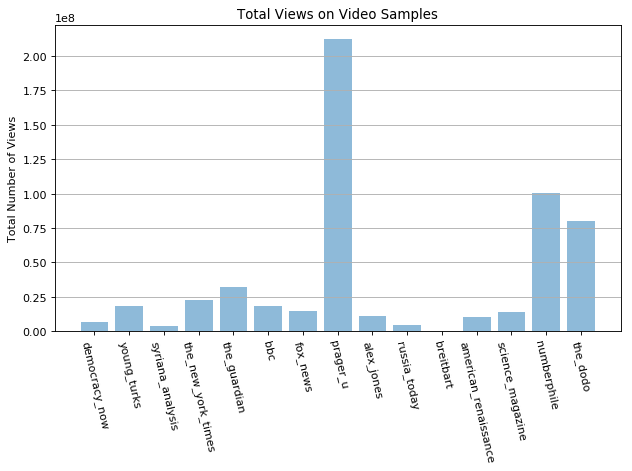

In [128]:
vals = []
for channel in dataset_names:
    vals.append(channelViews[channel])
cleanNames = [name[:-9] for name in dataset_names]

plt.figure(figsize=(8, 6), dpi=80)
plt.bar(cleanNames, vals, alpha=0.5)
plt.xticks(rotation=-77)
plt.grid(axis='y')
plt.title("Total Views on Video Samples")
plt.ylabel("Total Number of Views")
plt.tight_layout()

outname = "figures/Total_Views.png"
plt.savefig(outname)
plt.show()

In [129]:
def normalizeCountsByViews(s, data):
    for i, val in s.iteritems():
        _, _, stats = data[i]
        numViews = stats[3]
        newVal = float(val) / float(numViews)
        s[i] = newVal
        
def normalizeCountsByNumVideos(s, data):
    numVids = len(data)
    for i, val in s.iteritems():
        _, video_comments, _ = data[i]
        newVal = float(val) / float(numVids)
        s[i] = newVal

In [268]:
df3 = pd.DataFrame(columns=['Playlist','Num Authors', 'Num Videos', 'Num Views',
                            'All Comments/Views', 'All Comments/Views SEM',
                            'Direct Comments/Views', 'Direct Comments/Views SEM', 
                            'Replies/Views', 'Replies/Views SEM', 'All Comments/Num Videos', 'All Comments/Num Videos SEM',
                            'Direct Comments/Num Videos', 'Direct Comments/Num Videos SEM', 
                            'Replies/Num Videos', 'Replies/Num Videos SEM',
                            'Percentage Comments with a Reply',
                            'Num Replies/Comment','Num Replies/Comment SEM',
                            'Avg. Thread Length', 'Avg. Thread Length SEM',
                            'Comment Length', 'Comment Length SEM', 'Profane Rate', 'Profane Rate SEM'])
for i in range(len(frames)):
    print(dataset_names[i])
    df = frames[i]
    comment = df[df['Parent'].isnull()]
    com_with_reply = comment[comment["Num_Replies"] > 0]
    reply = df[df['Parent'].notnull()]
    raw_Data = tools[i].data
    totalComments = df.groupby('Video Title')['Comment'].count().astype('float').copy()
    normalizeCountsByViews(totalComments, raw_Data)
    
    directComments = comment.groupby('Video Title')['Comment'].count().astype('float').copy()
    normalizeCountsByViews(directComments, raw_Data)
    
    totReplies = reply.groupby('Video Title')['Comment'].count().astype('float').copy()
    normalizeCountsByViews(totReplies, raw_Data)
    
    totalCommentsByVid = df.groupby('Video Title')['Comment'].count().astype('float').copy()
    normalizeCountsByNumVideos(totalComments, raw_Data)
    
    directCommentsByVid = comment.groupby('Video Title')['Comment'].count().astype('float').copy()
    normalizeCountsByNumVideos(directComments, raw_Data)
    
    totRepliesByVid = reply.groupby('Video Title')['Comment'].count().astype('float').copy()
    normalizeCountsByNumVideos(totReplies, raw_Data)
    
    profane = df['Comment'].apply(lambda x: is_profane(x, bad_words))
    print(profane.mean(), profane.sem())
    df3.loc[i] = [
        dataset_names[i],
        len(df['Author'].unique()),
        len(df['Video Title'].unique()), #num videos
        channelViews[dataset_names[i]], #num total Views
        
        totalComments.mean(), #comments / view
        totalComments.sem(),
        
        directComments.mean(), #direct comments / view
        directComments.sem(), 
        
        totReplies.mean(), #replies / view
        totReplies.sem(),
        
        totalCommentsByVid.mean(), #comments / view
        totalCommentsByVid.sem(),
        
        directCommentsByVid.mean(), #direct comments / view
        directCommentsByVid.sem(), 
        
        totRepliesByVid.mean(), #replies / view
        totRepliesByVid.sem(),
        
        float(len(com_with_reply["Comment"])) / len(comment["Comment"]), #percentage comments with a reply

        reply.groupby('Parent')['Comment'].count().mean(), #replies / comment
        reply.groupby('Parent')['Comment'].count().sem(),
        
        comment["Num_Replies"].mean(), #Thread Length
        comment["Num_Replies"].sem(),
        
        df['Comment'].apply(lambda x: len(x)).mean(),
        df['Comment'].apply(lambda x: len(x)).sem(),
        
        profane.mean(),
        profane.sem(),
    ]

def remPlaylistTag(name):
    return name[:-9]
df3['Playlist'] = df3["Playlist"].apply(remPlaylistTag)
category = []
for i in range(len(frames)):
    category.append(categories[dataset_names[i]])
df3['Category'] = category
df4 = df3.groupby('Category', as_index=False).agg('mean')
df4.iloc[7,:], df4.iloc[0,:], df4.iloc[2,:] = df4.iloc[0,:], df4.iloc[2,:], df4.iloc[7,:]
df4.iloc[1,:], df4.iloc[3,:], df4.iloc[4,:] = df4.iloc[3,:], df4.iloc[4,:], df4.iloc[1,:]
df3

democracy_now_comments
10.354223433242506 0.11537639486878984
young_turks_comments
9.105274412232664 0.05476806764831716
syriana_analysis_comments
6.954472335490629 0.1555895282868715
the_new_york_times_comments
1.7642235952095107 0.050373035558098155
the_guardian_comments
5.1947807599318905 0.06806709068630482
bbc_comments
7.560679504107331 0.07869836357053889
fox_news_comments
5.0544351609286275 0.04979632167542963
prager_u_comments
7.334054186773441 0.040056133835514644
alex_jones_comments
8.266978519958037 0.08075314898964787
russia_today_comments
5.2592902119566 0.08473291550037801
breitbart_comments
10.081967213114755 0.32583109809876737
american_renaissance_comments
10.53842250662457 0.07290666295063929
science_magazine_comments
5.954368391764051 0.22790698771597503
numberphile_comments
0.7849070878055701 0.020227069404194296
the_dodo_comments
2.3593194989717703 0.03788900532436588


,Playlist,Num Authors,Num Videos,Num Views,All Comments/Views,All Comments/Views SEM,Direct Comments/Views,Direct Comments/Views SEM,Replies/Views,Replies/Views SEM,...,Percentage Comments with a Reply,Num Replies/Comment,Num Replies/Comment SEM,Avg. Thread Length,Avg. Thread Length SEM,Comment Length,Comment Length SEM,Profane Rate,Profane Rate SEM,Category
0,democracy_now,18633,200,6538679,0.000068,2.902676e-06,0.000028,9.380013e-07,0.000040,2.155412e-06,...,0.258103,5.313875,0.112259,1.371527,0.031990,235.121626,1.775519,10.354223,0.115376,Left Bias
1,young_turks,52134,200,18256007,0.000080,3.318905e-06,0.000028,8.981736e-07,0.000053,2.637859e-06,...,0.491610,3.754537,0.020926,1.845767,0.011923,155.066955,0.404911,9.105274,0.054768,Left Bias
2,syriana_analysis,8034,200,3773519,0.000104,4.903844e-06,0.000061,3.128578e-06,0.000044,2.520968e-06,...,0.197381,3.846949,0.128552,0.759313,0.028248,187.269126,2.286958,6.954472,0.155590,Left Bias
3,the_new_york_times,37535,200,22775993,0.000028,1.715561e-06,0.000013,6.411206e-07,0.000015,1.177345e-06,...,0.200012,5.627665,0.130219,1.125603,0.028914,154.215777,0.960165,1.764224,0.050373,Left-Center Bias
4,the_guardian,56063,200,32025243,0.000021,1.460116e-06,0.000009,5.212107e-07,0.000012,1.028447e-06,...,0.198862,6.990728,0.133424,1.390192,0.029648,175.518528,0.827815,5.194781,0.068067,Left-Center Bias
5,bbc,44835,200,18336131,0.000050,2.170491e-06,0.000020,7.788684e-07,0.000030,1.546694e-06,...,0.238692,7.166751,0.149978,1.710648,0.038803,154.323021,0.779157,7.560680,0.078698,Left-Center Bias
6,fox_news,54411,200,15170222,0.000104,3.849250e-06,0.000053,2.448906e-06,0.000051,1.938820e-06,...,0.164250,6.380839,0.107394,1.048055,0.019243,143.012571,0.459816,5.054435,0.049796,Right Bias
7,prager_u,129266,200,211789858,0.000027,1.651591e-06,0.000013,8.841254e-07,0.000014,8.873366e-07,...,0.188311,10.149609,0.110631,1.911288,0.023286,248.829370,0.693368,7.334054,0.040056,PragerU
8,alex_jones,41677,150,11125132,0.000078,2.946131e-06,0.000047,1.748682e-06,0.000031,1.446315e-06,...,0.132760,4.912146,0.089015,0.652138,0.013383,144.614950,0.775450,8.266979,0.080753,Conspiracy-Pseudoscience
9,russia_today,20887,200,4380743,0.000109,4.658775e-06,0.000054,2.370737e-06,0.000054,2.644729e-06,...,0.219684,4.654816,0.082317,1.022586,0.020862,136.746906,1.096732,5.259290,0.084733,Questionable Source


In [270]:
df4

,Category,All Comments/Views,All Comments/Views SEM,Direct Comments/Views,Direct Comments/Views SEM,Replies/Views,Replies/Views SEM,All Comments/Num Videos,All Comments/Num Videos SEM,Direct Comments/Num Videos,...,Replies/Num Videos SEM,Percentage Comments with a Reply,Num Replies/Comment,Num Replies/Comment SEM,Avg. Thread Length,Avg. Thread Length SEM,Comment Length,Comment Length SEM,Profane Rate,Profane Rate SEM
0,Left Bias,0.000084,3.708475e-06,0.000039,1.654918e-06,0.000045,2.438080e-06,620.630000,45.316167,235.923333,...,29.580132,0.315698,4.305120,0.087246,1.325535,0.024054,192.485902,1.489130,8.804657,0.108578
1,Left-Center Bias,0.000033,1.782056e-06,0.000014,6.470666e-07,0.000019,1.250829e-06,479.080000,65.855867,197.061667,...,44.344735,0.212522,6.595048,0.137874,1.408814,0.032455,161.352442,0.855712,4.839895,0.065713
2,Right Bias,0.000104,3.849250e-06,0.000053,2.448906e-06,0.000051,1.938820e-06,967.665000,65.421205,472.480000,...,34.811884,0.164250,6.380839,0.107394,1.048055,0.019243,143.012571,0.459816,5.054435,0.049796
3,PragerU,0.000027,1.651591e-06,0.000013,8.841254e-07,0.000014,8.873366e-07,2117.860000,141.335311,727.465000,...,116.457275,0.188311,10.149609,0.110631,1.911288,0.023286,248.829370,0.693368,7.334054,0.040056
4,Conspiracy-Pseudoscience,0.000078,2.946131e-06,0.000047,1.748682e-06,0.000031,1.446315e-06,775.293333,53.134254,469.266667,...,22.910121,0.132760,4.912146,0.089015,0.652138,0.013383,144.614950,0.775450,8.266979,0.080753
5,Pro-Science,0.000007,4.743810e-07,0.000004,2.202821e-07,0.000004,3.612017e-07,53.910000,17.626331,32.005000,...,7.443414,0.157163,4.354871,0.239573,0.684424,0.042532,139.179837,3.815127,5.954368,0.227907
6,Questionable Source,0.000094,4.888640e-06,0.000050,2.605056e-06,0.000049,3.132632e-06,477.685487,48.036826,211.792455,...,33.209066,0.199446,5.415030,0.194163,1.072925,0.040590,184.422397,1.886076,8.626560,0.161157
7,Apolitical,0.000013,4.498207e-07,0.000010,3.399026e-07,0.000004,1.589845e-07,877.027500,50.039517,602.197500,...,20.233120,0.102324,4.510679,0.090106,0.459607,0.009089,104.661097,0.447310,1.572113,0.029058


In [273]:
def plotMean(df, colName, title):
    column = df[colName]
    sem = df[colName + " SEM"]
    mean = np.mean(column)
    ylabel = colName
    
    if mean < 1e-4:
        column = column * 1e6
        sem = sem * 1e6
        ylabel = colName + " (In Millionths)"
    fig, ax = plt.subplots(figsize=(8, 6), dpi=80)
    rects = ax.bar(df['Category'], np.around(column, decimals=2), yerr=sem , align='center', alpha=0.5, ecolor='black', capsize=10)

    ax.set_ylabel(ylabel)
    # ax.set_xticks(x_pos)
    # ax.set_xticklabels(materials)
    for tick in ax.get_xticklabels():
        tick.set_rotation(-77)
    avgheight = np.mean([rect.get_height() for rect in rects])
    for i, rect in enumerate(rects):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2, height + sem[i], str(height), ha='center', va='bottom')
        
    ax.set_title(title)
    ax.yaxis.grid(True)

    #show
    plt.tight_layout()
    outname = "new_figures/" + colName.replace("/", "_").replace(" ", "_") + ".png"
    plt.savefig(outname, bbox="tight")
    plt.show()

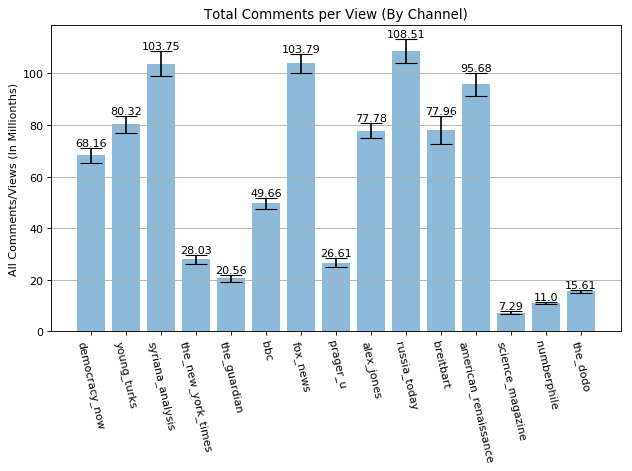

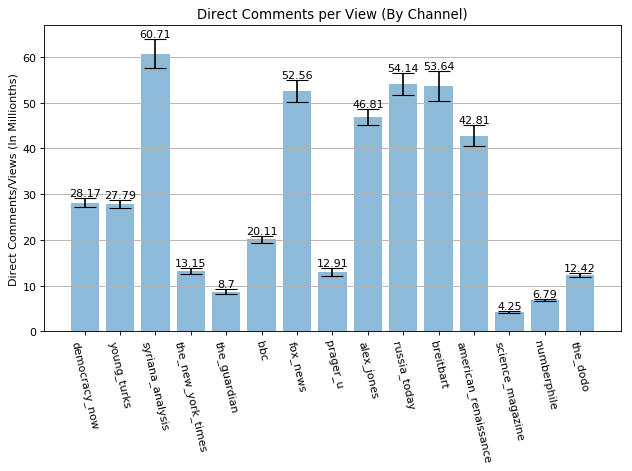

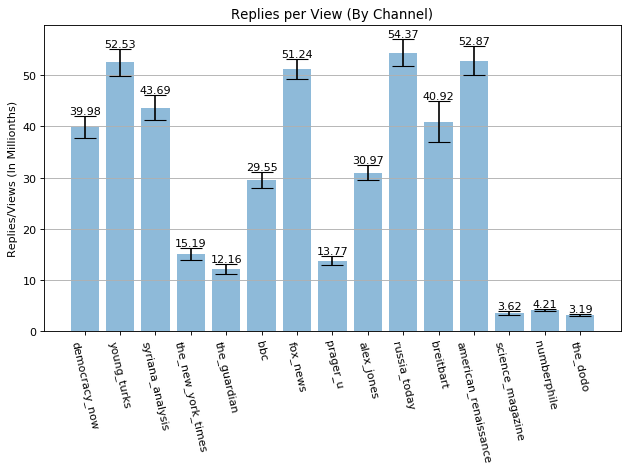

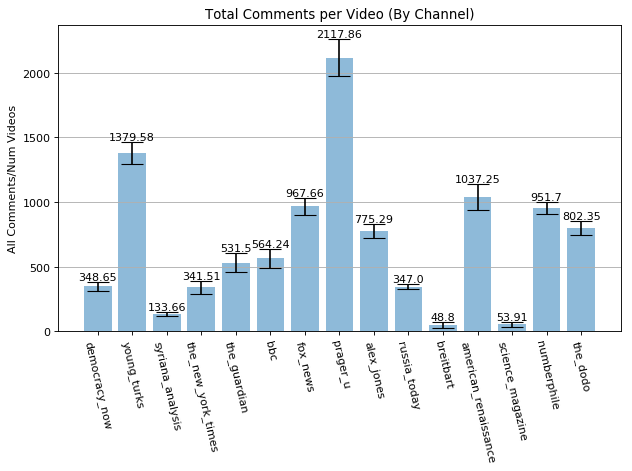

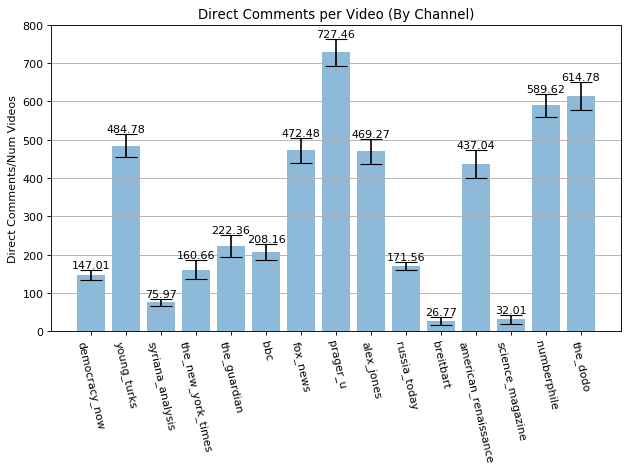

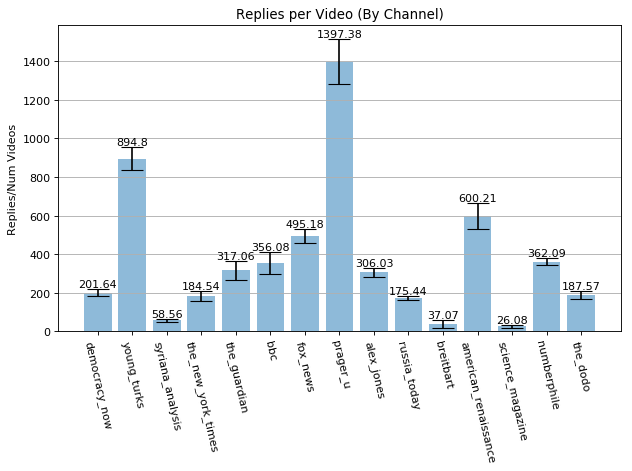

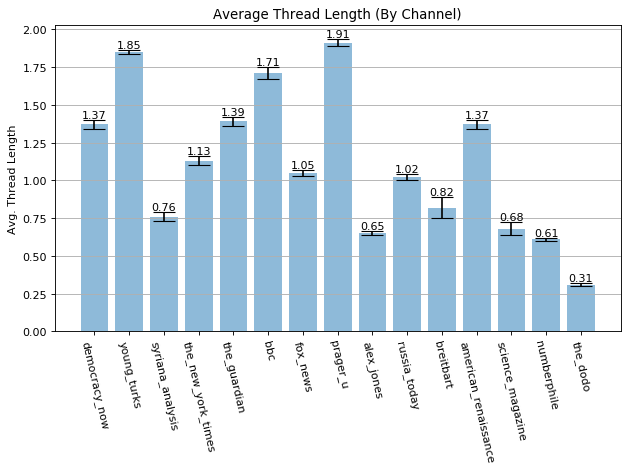

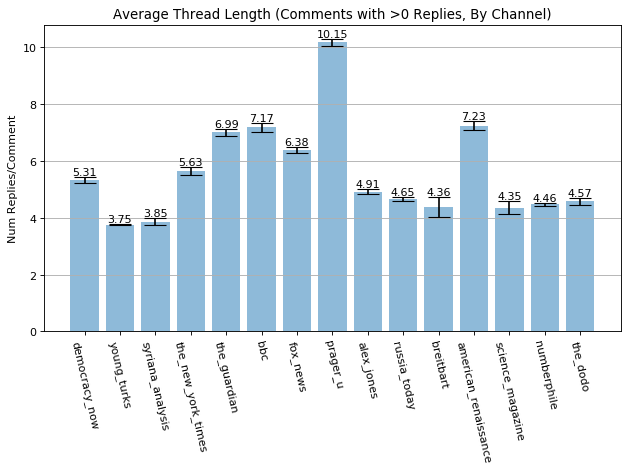

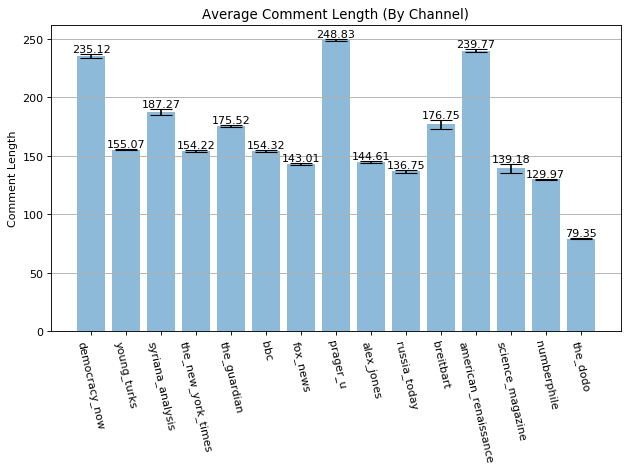

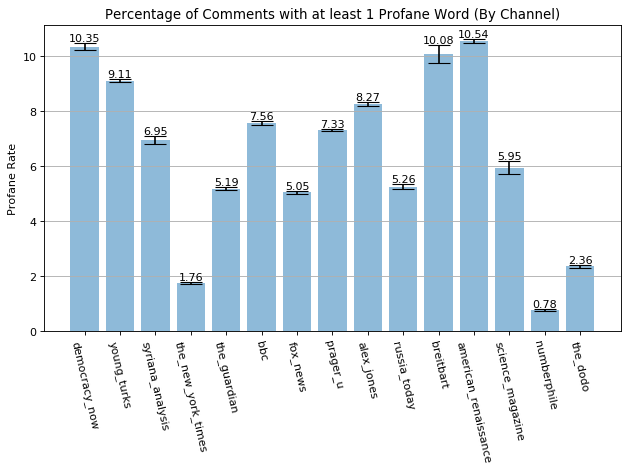

In [272]:
plotMean(df3, 'All Comments/Views', 'Total Comments per View (By Channel)')
plotMean(df3, 'Direct Comments/Views', 'Direct Comments per View (By Channel)')
plotMean(df3, 'Replies/Views', 'Replies per View (By Channel)')
plotMean(df3, 'All Comments/Num Videos', 'Total Comments per Video (By Channel)')
plotMean(df3, 'Direct Comments/Num Videos', 'Direct Comments per Video (By Channel)')
plotMean(df3, 'Replies/Num Videos', 'Replies per Video (By Channel)')
plotMean(df3, 'Avg. Thread Length', 'Average Thread Length (By Channel)')
plotMean(df3, 'Num Replies/Comment', 'Average Thread Length (Comments with >0 Replies, By Channel)')
plotMean(df3, 'Comment Length', 'Average Comment Length (By Channel)')
plotMean(df3, 'Profane Rate', 'Percentage of Comments with at least 1 Profane Word (By Channel)')

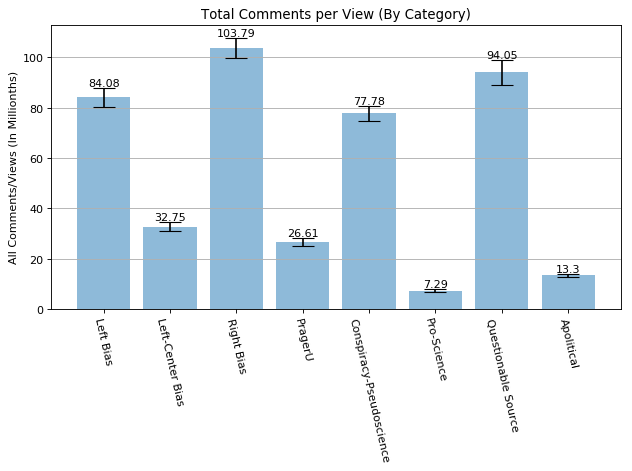

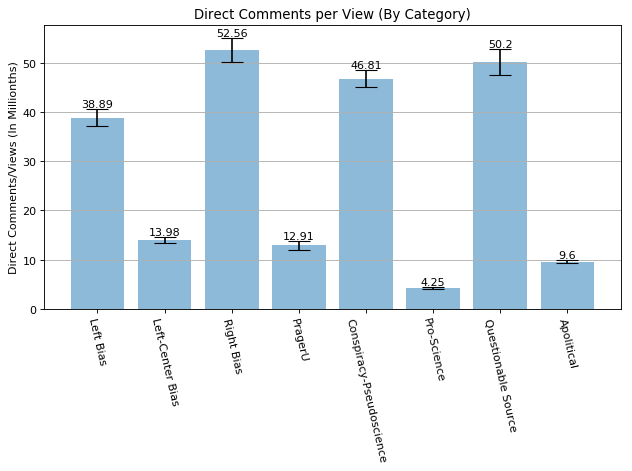

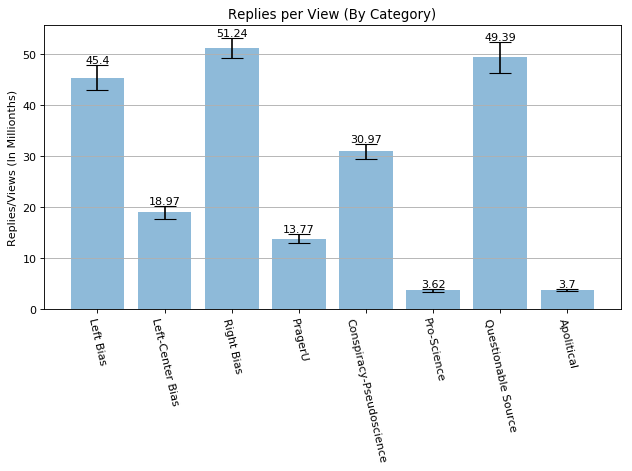

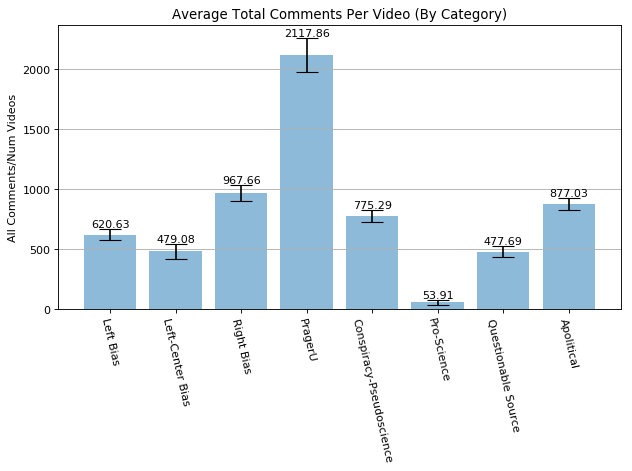

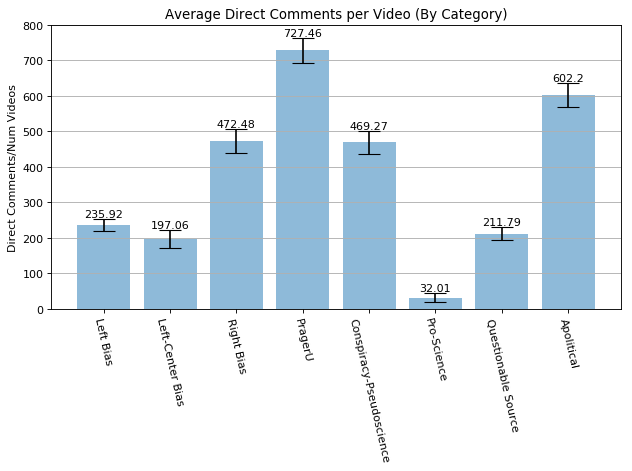

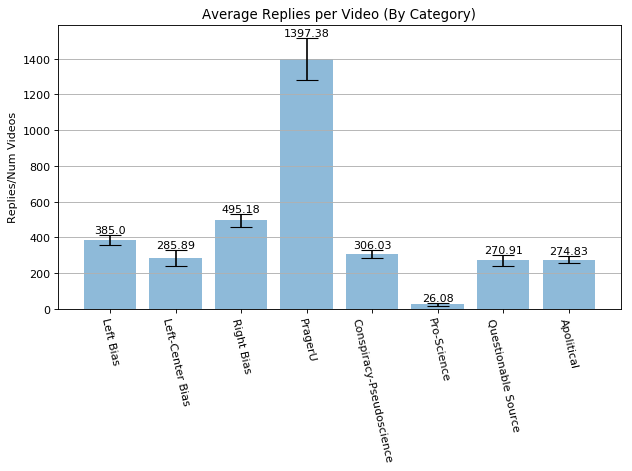

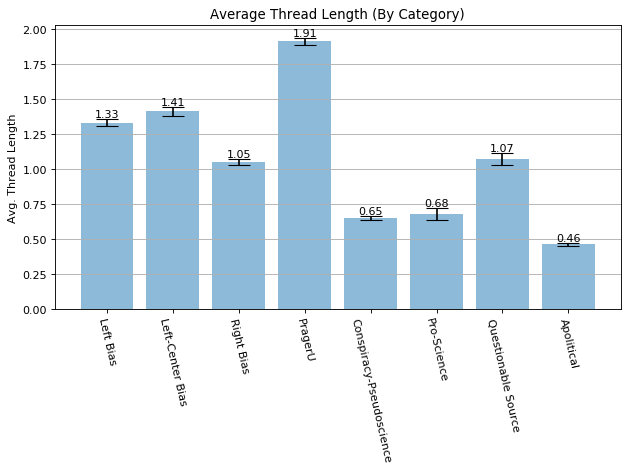

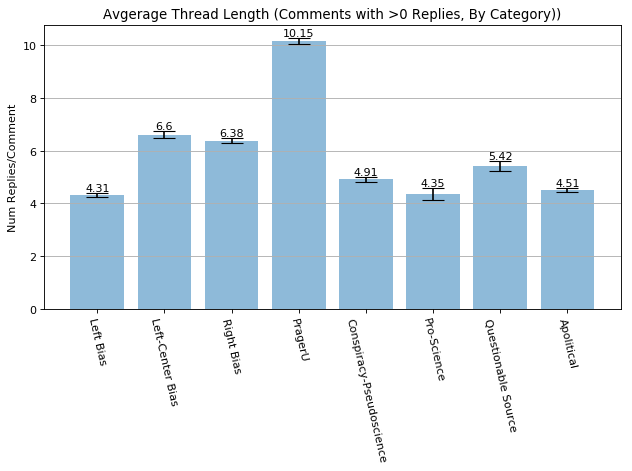

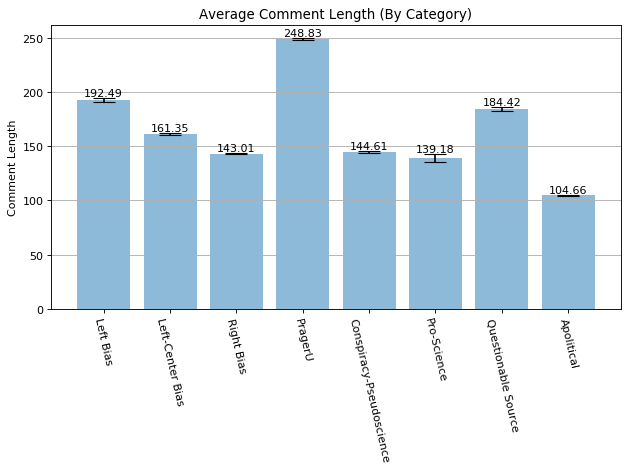

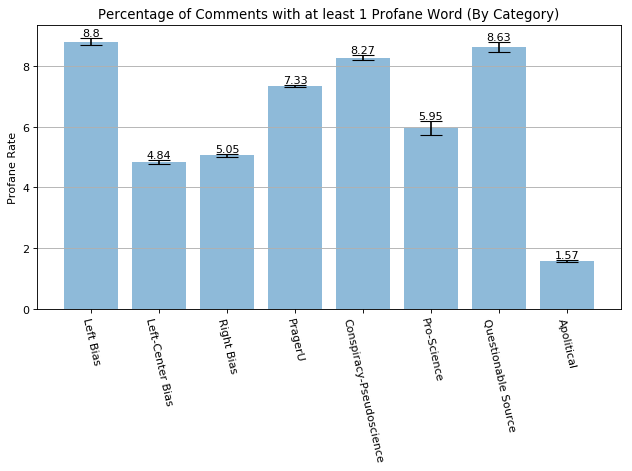

In [274]:
plotMean(df4, 'All Comments/Views', 'Total Comments per View (By Category)')
plotMean(df4, 'Direct Comments/Views', 'Direct Comments per View (By Category)')
plotMean(df4, 'Replies/Views', 'Replies per View (By Category)')
plotMean(df4, 'All Comments/Num Videos', 'Average Total Comments Per Video (By Category)')
plotMean(df4, 'Direct Comments/Num Videos', 'Average Direct Comments per Video (By Category)')
plotMean(df4, 'Replies/Num Videos', 'Average Replies per Video (By Category)')
plotMean(df4, 'Avg. Thread Length', 'Average Thread Length (By Category)')
plotMean(df4, 'Num Replies/Comment', 'Avgerage Thread Length (Comments with >0 Replies, By Category))')
plotMean(df4, 'Comment Length', 'Average Comment Length (By Category)')
plotMean(df4, 'Profane Rate', 'Percentage of Comments with at least 1 Profane Word (By Category)')

In [187]:
def compute_ratio(colName):
    left_bias = df4.iloc[0,colName]
    right_bias = df4.iloc[2,colName]
    consp = df4.iloc[4,colName]
    prager = df4.iloc[3,colName]
    quest = df4.iloc[6,colName]
    
    prosci = df4.iloc[5,colName]
    apo = df4.iloc[7,colName]
    
    print(np.mean([left_bias, right_bias, prager, consp, quest]) / np.mean([prosci, apo]))

print("Total Comments Ratio:")
compute_ratio(1)

print("Direct Comments Ratio:")
compute_ratio(3)

print("Replies Ratio:")
compute_ratio(5)

print("Left-Bias divided by Left-Center Bias")
print(df4.iloc[0,1] / df4.iloc[1,1])

print(df4.iloc[0,3] / df4.iloc[1,3])

print(df4.iloc[0,5] / df4.iloc[1,5])

print("")
print("Total Comments Ratio of Consp + Quest over Apo and Pro-Sci")
print((df4.iloc[4,1] + df4.iloc[6,1]) / (df4.iloc[5,1] + df4.iloc[7,1]))

print("")
print("Replies Ratio of Consp + Quest over Apo and Pro-Sci")
print((df4.iloc[4,5] + df4.iloc[6,5]) / (df4.iloc[5,5] + df4.iloc[7,5]))

Total Comments Ratio:
7.503747842267591
Direct Comments Ratio:
5.8142168332213355
Replies Ratio:
10.426586451887685
Left-Bias divided by Left-Center Bias
2.567119217128479
2.7810635402541903
2.393480938074001

Total Comments Ratio of Consp + Quest over Apo and Pro-Sci
8.34415365880997

Replies Ratio of Consp + Quest over Apo and Pro-Sci
10.980336054382633


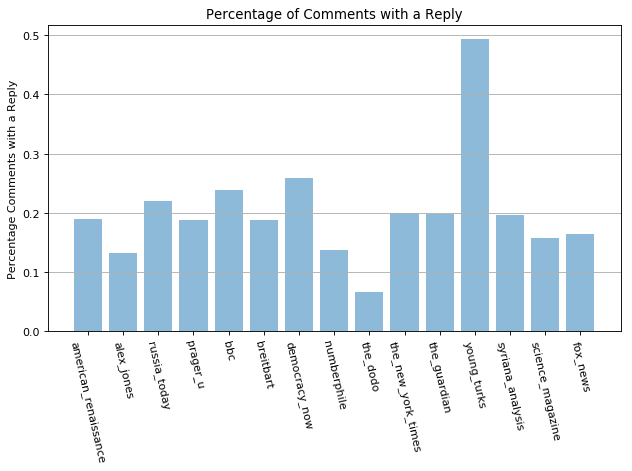

In [48]:
plt.figure(figsize=(8, 6), dpi=80)
plt.bar(df3["Playlist"], df3["Percentage Comments with a Reply"], alpha=0.5)
plt.ylabel("Percentage Comments with a Reply")
plt.title('Percentage of Comments with a Reply')
plt.grid(axis='y')
plt.xticks(rotation=-77)
plt.tight_layout()
outname = "new_figures/Percentage_Comments_w_Replies.png"
plt.savefig(outname)
plt.show()

             Like Count  Num_Replies
Like Count     1.000000     0.685054
Num_Replies    0.685054     1.000000


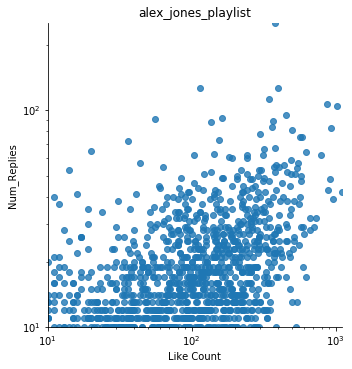

             Like Count  Num_Replies
Like Count     1.000000     0.672638
Num_Replies    0.672638     1.000000


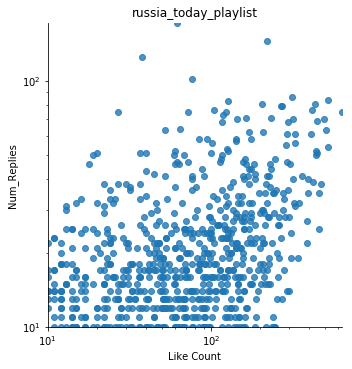

             Like Count  Num_Replies
Like Count     1.000000     0.532925
Num_Replies    0.532925     1.000000


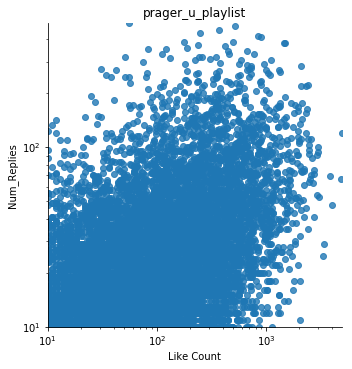

             Like Count  Num_Replies
Like Count     1.000000     0.551422
Num_Replies    0.551422     1.000000


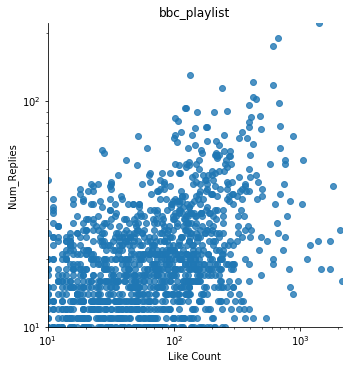

             Like Count  Num_Replies
Like Count     1.000000     0.473251
Num_Replies    0.473251     1.000000


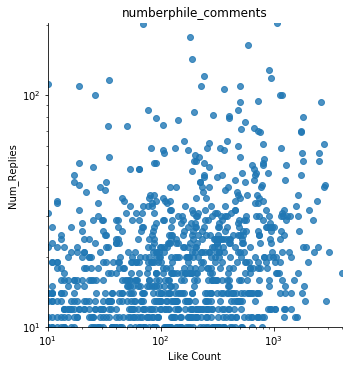

             Like Count  Num_Replies
Like Count     1.000000     0.631367
Num_Replies    0.631367     1.000000


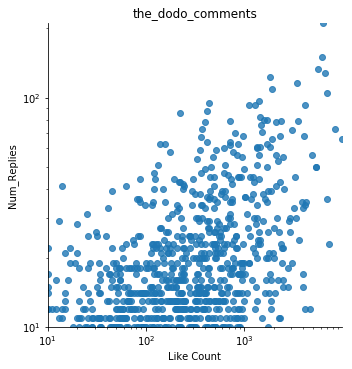

             Like Count  Num_Replies
Like Count     1.000000     0.534483
Num_Replies    0.534483     1.000000


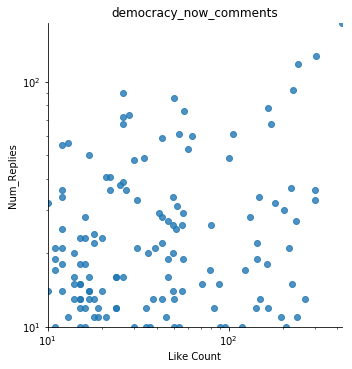

             Like Count  Num_Replies
Like Count     1.000000     0.340111
Num_Replies    0.340111     1.000000


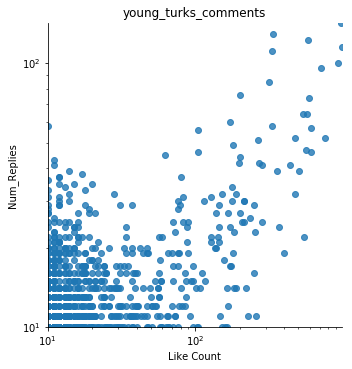

             Like Count  Num_Replies
Like Count     1.000000     0.496457
Num_Replies    0.496457     1.000000


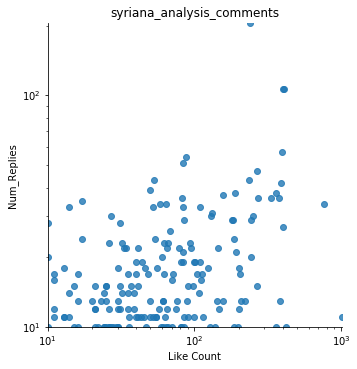

In [14]:
for i in range(len(frames)):
    df = frames[i]
    df = df[df['Is Reply'] == False]
    print(df[["Like Count","Num_Replies"]].corr())
    # basic scatterplot
    g = sns.lmplot( x="Like Count", y="Num_Replies", data=df, fit_reg=False)

    #Set log scale
    g.ax.set_xscale('log')
    g.ax.set_yscale('log')

    #Set Title
    g.ax.set_title(dataset_names[i])

    # control x and y limits
    g.ax.set_ylim(10, df["Num_Replies"].max())
    g.ax.set_xlim(10, df["Like Count"].max())
    
    #save plot
    g.savefig("figures/"+dataset_names[i] + '_likes_replies.png')
    
    #show plot
    plt.show()

In [15]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

alex_jones_playlist


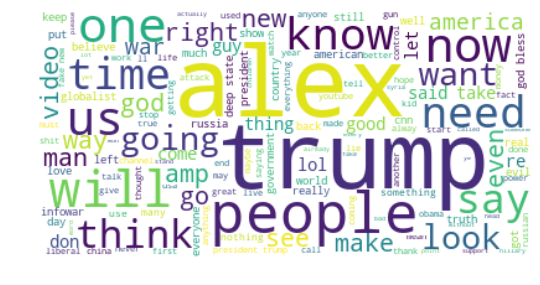

russia_today_playlist


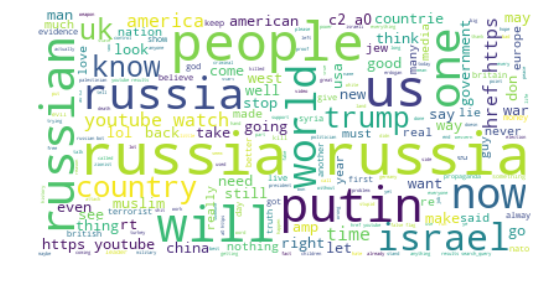

prager_u_playlist


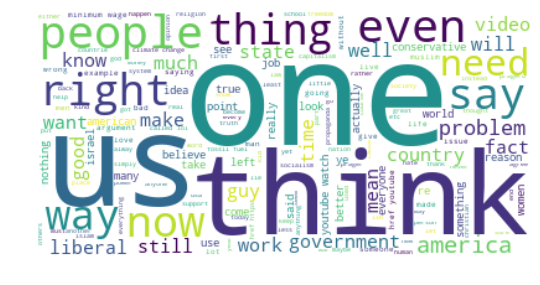

bbc_playlist


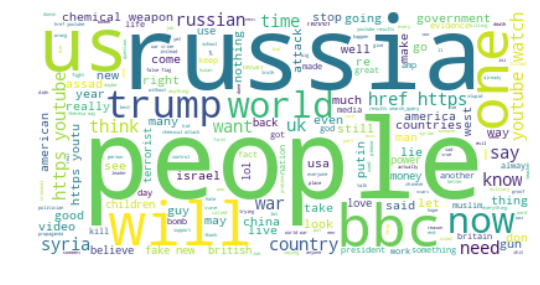

numberphile_comments


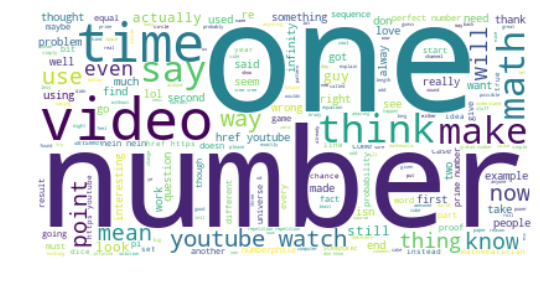

the_dodo_comments


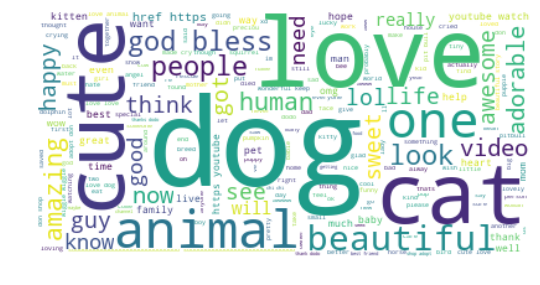

democracy_now_comments


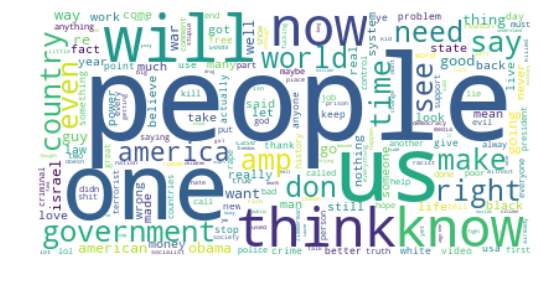

young_turks_comments


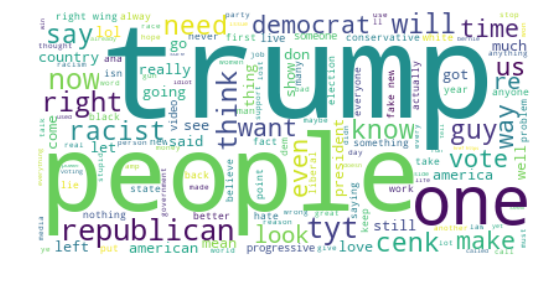

syriana_analysis_comments


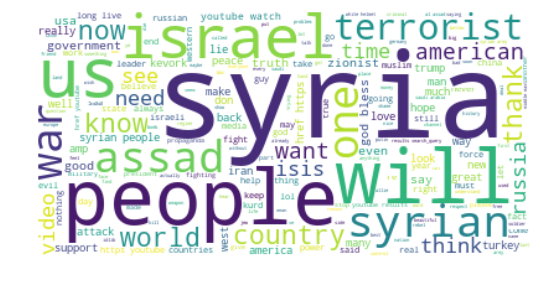

In [16]:
for i in range(len(dataset_names)):
    print(dataset_names[i])
    plt.figure(figsize=(8, 6), dpi=80)
    text = " ".join(comment.lower() for comment in frames[i][frames[i]['Parent'].isnull()].Comment)
    #frames[3][frames[3]['Parent'].isnull()].iloc[78226]
    #print ("There are {} words in the combination of all review.".format(len(text)))

    # Create stopword list:
    stopwords = set(STOPWORDS)
    stopwords.update(["br",'quot']) #???

    # Generate a word cloud image
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

    # Display the generated image:
    # the matplotlib way:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    outname = "figures/word_cloud_"+dataset_names[i]+".png"
    plt.savefig(outname)
    plt.show()